In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-18:] == 'VESUVIUS_Challenge':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/home/gregory_eritsyan/VESUVIUS_Challenge/jupyter notebooks
Current path:/home/gregory_eritsyan/VESUVIUS_Challenge


In [2]:
import monai
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from Data_Modules.MONAI_Dict_Dataset_Module import MONAI_CSV_Scrolls_Dataset
import matplotlib.patches as patches
#from lit_models.UNET_monai_lit import UNET_lit
from monai.visualize import matshow3d

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2023-04-25 05:24:01,269 - Created a temporary directory at /tmp/tmpodi9f3p2
2023-04-25 05:24:01,271 - Writing /tmp/tmpodi9f3p2/_remote_module_non_scriptable.py


In [3]:
KAGGLE_DIR = PATH / "kaggle"

INPUT_DIR = KAGGLE_DIR / "input"

COMPETITION_DATA_DIR = INPUT_DIR / "vesuvius-challenge-ink-detection"

TRAIN_DATA_CSV_PATH = COMPETITION_DATA_DIR / "data_train_0.5.csv"
TEST_DATA_CSV_PATH = COMPETITION_DATA_DIR / "data_test_1.csv"
TEST_DOWNSAMPLED_DATA_CSV_PATH = COMPETITION_DATA_DIR /"data_test_0.5.csv"
TEST_DOWNSAMPLED_HALf_DATA_CSV_PATH = COMPETITION_DATA_DIR /"data_test_0.75.csv"


In [4]:

from typing import Tuple, List


import monai
from monai.inferers import sliding_window_inference
import pytorch_lightning as pl

import torch

from torchmetrics import Dice, FBetaScore
from torchmetrics import MetricCollection
from tqdm.auto import tqdm
try:
    import wandb
except ModuleNotFoundError:
    pass

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")
class UNET_lit(pl.LightningModule):
    def __init__(
        self,
        use_wandb = True,
        z_dim= 16,
        patch_size = (512,512),
        sw_batch_size=16 ,
        eta_min = 1e-6,
        t_max = 200,
        max_epochs = 700,
        weight_decay: float = 0.00005,
        learning_rate: float = 0.0003,
        gamma: float = 0.85,
        milestones: List[int] = [  100, 150, 200, 250, 300, 350, 400, 450, 500],
    ):
        super().__init__()

        self.save_hyperparameters()

        if use_wandb:
            wandb.init()
        self.z_dim = z_dim
        self.metrics = self._init_metrics()
        self.lr = learning_rate
        self.gamma = gamma
        self.weight_decay = weight_decay
        self.milestones = milestones

        self.model = self._init_model()
        self.loss = self._init_loss()



    def _init_model(self):
        return monai.networks.nets.UNet(
                            spatial_dims=2,
                            in_channels= self.z_dim,
                            out_channels=1,
                            channels=( 64, 128, 256, 512, 1024,2048),
                            strides=(2, 2, 2, 2,2 ),
                            num_res_units=6,
                            dropout=0,
                        )

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images = batch["volume_npy"].as_tensor().to(DEVICE)
        labels = batch["label_npy"].long().to(DEVICE)
        masks = batch["mask_npy"].to(DEVICE)
        outputs = self.model(images)

        loss = self.loss(outputs, labels, masks)

        self.log("train/loss", loss.as_tensor(), on_step=True,on_epoch=True, prog_bar=True)
        self.metrics["train_metrics"](outputs, labels)
        wandb.log({"train/loss": loss.as_tensor()})

        outputs = {"loss": loss}

        return loss

    def validation_step(self, batch, batch_idx):
        images = batch["volume_npy"].as_tensor().to(DEVICE)
        labels = batch["label_npy"].long().to(DEVICE)
        masks = batch["mask_npy"].to(DEVICE)
        outputs = self.model(images)

        loss = self.loss(outputs, labels, masks)
        preds = torch.sigmoid(outputs.detach()).gt(.4).int()

        accuracy = (preds == labels).sum().float().div(labels.size(0) * labels.size(2) ** 2)
        fbeta_score = FBetaScore(task="binary", beta=.5, threshold=.4).to(DEVICE)
        fbeta = fbeta_score(torch.sigmoid(outputs), labels)
        #fbeta_score_vesuvio = self.fbeta_score_vesuvio(torch.sigmoid(outputs).to(dtype=torch.long, device=DEVICE),labels, 0.4 )


        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("accuracy", accuracy, on_step=False, on_epoch=True, prog_bar=True)
        self.log("fbeta", fbeta, on_step=False, on_epoch=True, prog_bar=True)
        #self.log("fbeta_vesuvio", fbeta_score_vesuvio, on_step=False, on_epoch=True, prog_bar=True)
        self.metrics["val_metrics"](outputs, labels)

        wandb.log({"val/loss": loss.as_tensor()})
        wandb.log({"accuracy": accuracy.as_tensor()})
        wandb.log({"fbeta": fbeta.as_tensor()})
        #wandb.log({"fbeta_vesuvio": fbeta_score_vesuvio.as_tensor()})


        outputs = {"loss": loss}

        return loss


    def predict_step(self, batch, batch_idx):
        images = batch["volume_npy"].as_tensor()
        masks = batch["mask_npy"].as_tensor()
        h ,w = images.shape[2], images.shape[3]
        h_mod = h % 1024
        w_mod = w % 1024
        h -= h_mod
        w -= w_mod
        outputs = sliding_window_inference(
            inputs=images,
            roi_size= (h, w),# ( 1024,2048),# (h, w), #self.hparams.patch_size,
            sw_batch_size=self.hparams.sw_batch_size,
            predictor=self,
            overlap=0.05,
            mode='gaussian',
           
            
        )
        return outputs.sigmoid().squeeze()



    def _init_loss(self):

        loss = monai.losses.DiceLoss(sigmoid=True)
        return monai.losses.MaskedLoss(loss)

    def _init_metrics(self):
        metric_collection = MetricCollection(
            {
                "dice": Dice(),
            }
        )

        return torch.nn.ModuleDict(
            {
                "train_metrics": metric_collection.clone(prefix="train_"),
                "val_metrics": metric_collection.clone(prefix="val_"),
            }
        )


    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.milestones, gamma=self.gamma)
        scheduler =  torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.t_max,  eta_min=self.hparams.eta_min, )
        return [optimizer], [scheduler]

    #torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs,  eta_min=self.hparams.eta_min, )




In [5]:
lit_model = UNET_lit( 
        use_wandb = False,
        z_dim = 32,
        patch_size = (512,512),
        sw_batch_size=16 ,
        eta_min = 1e-6,
        t_max = 75,
        max_epochs = 700,
        weight_decay = 0.00005,
        learning_rate = 0.0003,
        gamma = 0.85,)

In [6]:
trainer = pl.Trainer(
        accelerator='cpu',
        #benchmark=True,
        max_epochs=700,
        check_val_every_n_epoch= 1,
        devices=1,
        #fast_dev_run=fast_dev_run,
        logger=pl.loggers.CSVLogger(save_dir='logs/up1024/'),
        log_every_n_steps=1,
        
        overfit_batches=0,
        #precision=16,
         accumulate_grad_batches=1,
)


2023-04-25 05:24:04,237 - GPU available: True (cuda), used: False
2023-04-25 05:24:04,288 - TPU available: False, using: 0 TPU cores
2023-04-25 05:24:04,289 - IPU available: False, using: 0 IPUs
2023-04-25 05:24:04,289 - HPU available: False, using: 0 HPUs


/home/gregory_eritsyan/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


In [7]:
lit_model = lit_model.load_from_checkpoint('logs/monai_32_2048_epoch550.ckpt', 
                                           patch_size = (512,512),
                                           use_wandb=False,
                                          sw_batch_size = 8)


In [8]:
data_module = MONAI_CSV_Scrolls_Dataset(
                z_dim=32,
                batch_size=1,
                data_csv_path= TEST_DOWNSAMPLED_DATA_CSV_PATH, #TEST_DOWNSAMPLED_DATA_CSV_PATH,#TEST_DATA_CSV_PATH,
                num_workers=16,
                num_samples=4,
                patch_size=(512,512),
                val_fragment_id=3,
                stage='predict',
                on_gpu =False,
                    )

data_module.setup(stage='predict')


In [9]:
lit_model.eval()
predictions = trainer.predict( lit_model, data_module,)

Predicting: 0it [00:00, ?it/s]

torch.Size([1363, 3165])


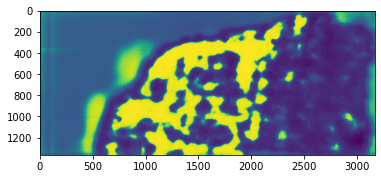

In [10]:
plt.imshow(predictions[0])
print(predictions[0].shape)

torch.Size([1363, 3165])


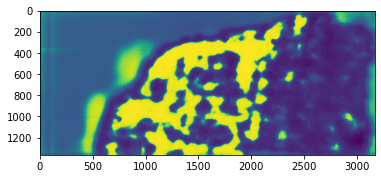

In [11]:
plt.imshow(predictions[0])
print(predictions[0].shape)

torch.Size([2727, 3165])


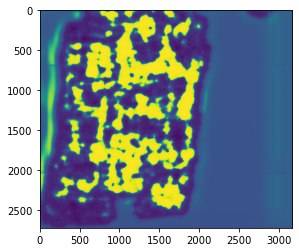

In [12]:
print(predictions[1].shape)
plt.imshow(predictions[1])

torch.Size([2727, 3165])


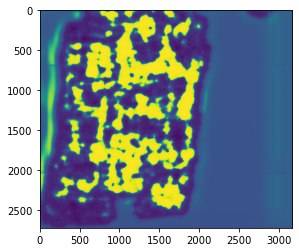

In [13]:
print(predictions[1].shape)
plt.imshow(predictions[1])

torch.Size([2727, 3165])


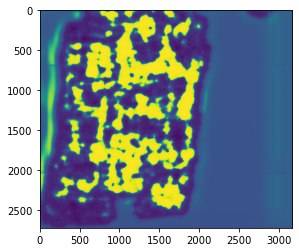

In [14]:
print(predictions[1].shape)
plt.imshow(predictions[1])

In [15]:
def plot_image(image, title):
    fig = plt.figure()
    plt.title(title)
    plt.imshow(image, cmap="gray")
    
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(int)
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [16]:
import pandas as pd
import PIL.Image as Image
import numpy as np
import lovely_numpy as ln

submission_df = pd.read_csv("kaggle/input/vesuvius-challenge-ink-detection/sample_submission.csv")


In [17]:
test_df = pd.read_csv("kaggle/input/vesuvius-challenge-ink-detection/data_test_1.csv")


,Id,Predicted
0,a,675872 5 682198 11 682213 1 688522 2 688527 18...
1,b,2212 7 2223 1 2231 2 3158 38 3198 20 3219 8 32...


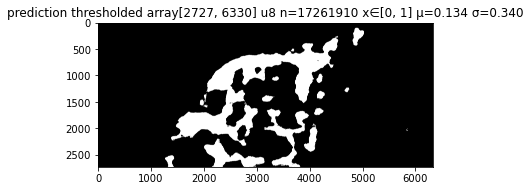

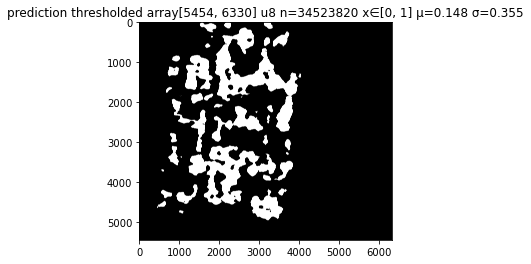

In [22]:
predictions_rle = []
predictions_old = []
THRESHOLD = .95
for mask_png_path, prediction in zip(test_df["mask_png"].values, predictions):
    prediction = prediction.numpy()
    mask = Image.open(mask_png_path)

    prediction_resized = np.array(Image.fromarray(prediction).resize(mask.size))
    
    prediction_masked = prediction_resized * mask
    
    prediction_thresholded = np.where(prediction_masked > THRESHOLD, 1, 0).astype(np.uint8)
    
    prediction_rle = rle(prediction_thresholded)

    predictions_rle.append(prediction_rle)
    
    
    predictions_old.append(prediction_thresholded)

    if 1:
        #plot_image(prediction_resized, f"prediction resized {ln.lovely(prediction_resized)}")
        #plot_image(prediction_masked, f"prediction masked {ln.lovely(prediction_masked)}")
        plot_image(
            prediction_thresholded,
            f"prediction thresholded {ln.lovely(prediction_thresholded)}",
        )
    
submission_df["Predicted"] = predictions_rle
    
submission_df.to_csv("logs/submission.csv", index=False)

submission_df

,Id,Predicted
0,a,853111 4 960701 1 967029 16 973356 22 979686 1...
1,b,21198 12 22151 3 22163 19 22190 25 22223 2 222...


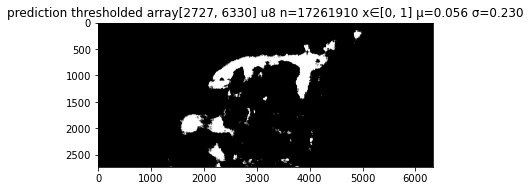

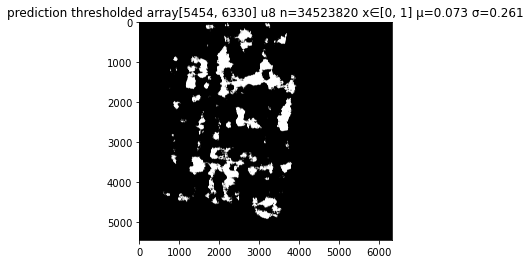

In [28]:
predictions_rle = []
predictions_old = []
THRESHOLD = .983
for mask_png_path, prediction in zip(test_df["mask_png"].values, predictions):
    prediction = prediction.numpy()
    mask = Image.open(mask_png_path)

    prediction_resized = np.array(Image.fromarray(prediction).resize(mask.size))
    
    prediction_masked = prediction_resized * mask
    
    prediction_thresholded = np.where(prediction_masked > THRESHOLD, 1, 0).astype(np.uint8)
    
    prediction_rle = rle(prediction_thresholded)

    predictions_rle.append(prediction_rle)
    
    
    predictions_old.append(prediction_thresholded)

    if 1:
        #plot_image(prediction_resized, f"prediction resized {ln.lovely(prediction_resized)}")
        #plot_image(prediction_masked, f"prediction masked {ln.lovely(prediction_masked)}")
        plot_image(
            prediction_thresholded,
            f"prediction thresholded {ln.lovely(prediction_thresholded)}",
        )
    
submission_df["Predicted"] = predictions_rle
    
submission_df.to_csv("logs/submission.csv", index=False)

submission_df

## Other type submission

from skimage.transform import resize as resize_ski
import PIL.Image as Image

DATA_DIR = "/kaggle/input/vesuvius-challenge-ink-detection"
mask_a = Image.open(COMPETITION_DATA_DIR / "test/a/mask.png")
mask_b = Image.open(COMPETITION_DATA_DIR /"test/b/mask.png")
original_size_a = mask_a.size
original_size_b = mask_b.size
predictions_map_a = resize_ski(predictions[0], (original_size_a[1], original_size_a[0])).squeeze()
predictions_map_b = resize_ski(predictions[1], (original_size_b[1], original_size_b[0])).squeeze()
predictions_map_a = predictions_map_a *mask_a
predictions_map_b =  predictions_map_b *mask_b

print(predictions_map_b.shape)
plt.imshow(predictions_map_b)


def rle_new(predictions_map, threshold):
    flat_img = predictions_map.flatten()
    flat_img = np.where(flat_img > threshold, 1, 0).astype(np.uint8)

    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))



threshold = 0.9

rle_a = rle_new(predictions_map_a, threshold=threshold)
rle_b = rle_new(predictions_map_b, threshold=threshold)
print("Id,Predicted\na," + rle_a + "\nb," + rle_b, file=open('submission.csv', 'w'))

COMARE SUBMISSIONS

submission_old = pd.read_csv('logs/submission.csv')
submission_new = pd.read_csv('submission.csv')

plot_image(
            prediction_thresholded,
            f"prediction thresholded {ln.lovely(prediction_thresholded)}",
        )

In [20]:
data_module.df


,Unnamed: 0,mask_png,stage,fragment_id,mask_npy,volumes_dir,volume_npy
0,0,/home/gregory_eritsyan/VESUVIUS_Challenge/kagg...,test,a,/home/gregory_eritsyan/VESUVIUS_Challenge/kagg...,/home/gregory_eritsyan/VESUVIUS_Challenge/kagg...,/home/gregory_eritsyan/VESUVIUS_Challenge/kagg...
1,1,/home/gregory_eritsyan/VESUVIUS_Challenge/kagg...,test,b,/home/gregory_eritsyan/VESUVIUS_Challenge/kagg...,/home/gregory_eritsyan/VESUVIUS_Challenge/kagg...,/home/gregory_eritsyan/VESUVIUS_Challenge/kagg...
